In [1]:
from oddt.scoring.descriptors import universal_descriptor
from oddt.fingerprints import PLEC
from oddt.toolkits import rdk, ob

from statistical_tests import bootstrap_pearsonr, permutation_pearsonr

import json
import numpy as np
from joblib import delayed, Parallel
from functools import partial
from sklearn.ensemble import RandomForestRegressor

from scipy import sparse, stats

from oddt.fingerprints import sparse_to_csr_matrix, csr_matrix_to_sparse, fold, sparse_to_dense
from matplotlib import pyplot as plt
import json
import pandas as pd

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

PDBBIND_DIR = '/home/fergus/pdbbind/v2019'

In [2]:
with open('../data/pdbbind_training_set.txt') as f:
    train_pdbs = [l.strip() for l in f]
    
with open('../data/pdbbind_test_set.txt') as f:
    test_pdbs = [l.strip() for l in f]

In [3]:
@delayed
def build(pdb):
    protein = next(ob.readfile('pdb', f'{PDBBIND_DIR}/{pdb}/{pdb}_protein.pdb'))
    protein.protein = True
    # crystal
    ligand = next(ob.readfile('sdf', f'{PDBBIND_DIR}/{pdb}/{pdb}_ligand.sdf'))
    features_c = PLEC(ligand, protein, depth_ligand=1, depth_protein=5, size=65536, count_bits=True, sparse=True, ignore_hoh=True)
    # docked        
    ligand = next(ob.readfile('sdf', f'../pdbbind_docked_poses/{pdb}/{pdb}_ligand_docked.sdf'))
    features_d = PLEC(ligand, protein, depth_ligand=1, depth_protein=5, size=65536, count_bits=True, sparse=True, ignore_hoh=True)
    return (features_c, features_d)

In [114]:
plecs_xtal = {}

with Parallel(n_jobs=6, verbose=10) as parallel:
    plecs_xtal = parallel(build_plec(pdb) for pdb in pdbs)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    2.4s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:    4.1s
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:   11.0s
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   15.2s
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   22.2s
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:   31.7s
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:   33.2s
[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed:   35.7s
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed:   40.3s
[Parallel(n_jobs=6)]: Done 101 tasks      | elapsed:   46.7s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:   51.0s
[Parallel(n_jobs=6)]: Done 133 tasks      | elapsed:   55.4s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 169 tasks      | elapsed:  1.3min
[Parallel(

In [113]:

with open('pdbbind_training_set_docked_plec_sparse.json', 'w') as f:
    json.dump(plecs, f, cls=NumpyEncoder)

In [115]:
with open('pdbbind_training_set_crystal_plec_sparse.json', 'w') as f:
    json.dump(plecs_xtal, f, cls=NumpyEncoder)

In [121]:
y = []
x_docked = []
x_crystal = []
labels = []
for plec_docked, plec_crystal, pdb in zip(plecs, plecs_xtal, pdbs):
    y.append(1)
    x_docked.append(sparse_to_csr_matrix(plec_docked, size=65536))
    x_crystal.append(sparse_to_csr_matrix(plec_crystal, size=65536))
    labels.append(pdb)
    #x.append(sparse_to_dense(plec, size=65536).tolist())
x_crystal = sparse.vstack(x_crystal, format='csr')
x_docked = sparse.vstack(x_docked, format='csr')

In [125]:
1792298/1916168 * 100

93.53553550628129

In [126]:
1916168/len(pdbs)

510.7057569296375

Docked poses have approx 93% the number of 'on' bits as crystal poses. Average of 510 of ~65.5k bits so very sparse!

In [122]:
x_crystal

<3752x65536 sparse matrix of type '<class 'numpy.uint8'>'
	with 1916168 stored elements in Compressed Sparse Row format>

In [123]:
x_docked

<3752x65536 sparse matrix of type '<class 'numpy.uint8'>'
	with 1792298 stored elements in Compressed Sparse Row format>

In [73]:
from oddt.fingerprints import sparse_to_csr_matrix, csr_matrix_to_sparse, fold

In [8]:
with Parallel(n_jobs=6, verbose=10) as parallel:
    test_features = parallel(build(pdb) for pdb in test_pdbs)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    2.1s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    3.0s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:    7.5s
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:   10.1s
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   16.0s
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   20.5s
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:   26.3s
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:   44.0s
[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed:   52.0s
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 101 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 133 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 169 tasks      | elapsed:  2.4min
[Parallel(

In [14]:
test_features_crystal = {}
test_features_docked = {}

for feature, pdb in zip(test_features, test_pdbs):
    test_features_crystal[pdb] = feature[0]
    test_features_docked[pdb] = feature[1]
    
with open('pdbbind_test_set_docked_plec_sparse.json', 'w') as f:
    json.dump(test_features_docked, f, cls=NumpyEncoder)
    
with open('pdbbind_test_set_crystal_plec_sparse.json', 'w') as f:
    json.dump(test_features_crystal, f, cls=NumpyEncoder)

In [19]:
with open('pdbbind_training_set_docked_plec_sparse.json') as f:
    train_features_docked = json.load(f)
    
with open('pdbbind_training_set_crystal_plec_sparse.json') as f:
    train_features_crystal = json.load(f)

In [20]:
with open('pdbbind_test_set_docked_plec_sparse.json') as f:
    test_features_docked = json.load(f)
    
with open('pdbbind_test_set_crystal_plec_sparse.json') as f:
    test_features_crystal = json.load(f)

In [21]:
train_affinity = pd.read_csv('../data/pdbbind_training_set_binding_affinity.csv', index_col=0, header=None, squeeze=True)
test_affinity = pd.read_csv('../data/pdbbind_test_set_binding_affinity.csv', index_col=0, header=None, squeeze=True)

In [8]:
y_train = []
X_train_crystal = []
X_train_docked = []
labels = []
for plec_docked, plec_crystal, pdb in zip(train_features_crystal, train_features_docked, train_pdbs):
    X_train_crystal.append(sparse_to_csr_matrix(plec_crystal, size=65536))
    X_train_docked.append(sparse_to_csr_matrix(plec_docked, size=65536))
    y_train.append(train_affinity.loc[pdb])
X_train_crystal = sparse.vstack(X_train_crystal, format='csr')
X_train_docked = sparse.vstack(X_train_docked, format='csr')

In [9]:
y_test = []
X_test_crystal = []
X_test_docked = []
labels = []
for pdb in test_pdbs:
    X_test_crystal.append(sparse_to_csr_matrix(test_features_crystal[pdb], size=65536))
    X_test_docked.append(sparse_to_csr_matrix(test_features_docked[pdb], size=65536))
    y_test.append(test_affinity.loc[pdb])
X_test_crystal = sparse.vstack(X_test_crystal, format='csr')
X_test_docked = sparse.vstack(X_test_docked, format='csr')

In [38]:
%%time
rf_crystal = RandomForestRegressor(n_estimators=500, max_features=0.33,random_state=42, n_jobs=8, oob_score=True)
rf_crystal.fit(X_train_crystal, y_train)
rf_docked = RandomForestRegressor(n_estimators=500, max_features=0.33,random_state=42, n_jobs=8, oob_score=True)
rf_docked.fit(X_train_docked, y_train)

CPU times: user 1h 54min 36s, sys: 9.37 s, total: 1h 54min 45s
Wall time: 15min 32s


RandomForestRegressor(max_features=0.33, n_estimators=500, n_jobs=8,
                      oob_score=True, random_state=42)

In [39]:
predicted_crystal = rf_crystal.predict(X_test_crystal)
predicted_docked = rf_docked.predict(X_test_docked)

0.7036850723759726


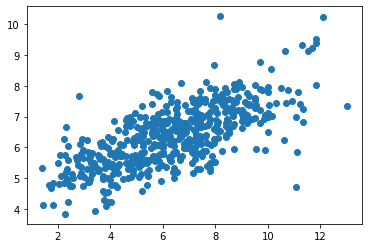

In [44]:
plt.scatter(y_test, predicted_crystal)
print(stats.pearsonr(y_test, predicted_crystal)[0])

0.6589021380413864


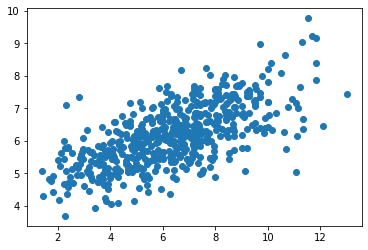

In [45]:
plt.scatter(y_test, predicted_docked)
print(stats.pearsonr(y_test, predicted_docked)[0])

In [47]:
%%time

# using original plecscore params
plecscore_crystal = RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=8, oob_score=True)
plecscore_crystal.fit(X_train_crystal, y_train)
plecscore_docked = RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=8, oob_score=True)
plecscore_docked.fit(X_train_docked, y_train)

CPU times: user 42min 54s, sys: 3 s, total: 42min 57s
Wall time: 5min 52s


RandomForestRegressor(n_jobs=8, oob_score=True, random_state=0)

In [48]:
predicted_plecscore_crystal = plecscore_crystal.predict(X_test_crystal)
predicted_plecscore_docked = plecscore_docked.predict(X_test_docked)

0.6855406644517302


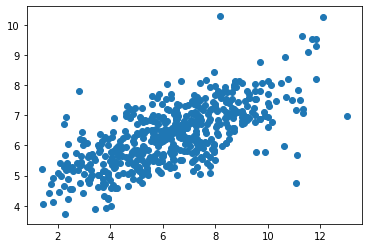

In [49]:
plt.scatter(y_test, predicted_plecscore_crystal)
print(stats.pearsonr(y_test, predicted_plecscore_crystal)[0])

0.6449895681766727


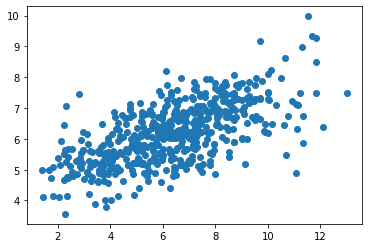

In [50]:
plt.scatter(y_test, predicted_plecscore_docked)
print(stats.pearsonr(y_test, predicted_plecscore_docked)[0])

In [6]:
del train_features_docked
del test_features_docked
del train_features_dense_docked
del test_features_dense_docked

NameError: name 'train_features_dense_docked' is not defined

In [7]:
pdbbind_training_set = pd.Index(train_pdbs)
pdbbind_test_set = pd.Index(test_pdbs)

In [8]:
blast_clusters = {}
for cutoff in [30, 40, 50, 70, 90, 95, 100]:
    with open(f'../data/bc-{cutoff}.out') as f:
        blast_clusters[cutoff] = [set(item[:4].lower() for item in line.strip().split()) for line in f]

test_set_similar_pdbs = {}
for cutoff in blast_clusters:
    pdbs = set()
    for pdb in pdbbind_test_set:
        for cluster in blast_clusters[cutoff]:
            if pdb in cluster:
                pdbs.update(cluster)
    test_set_similar_pdbs[cutoff] = pd.Index(pdbs).intersection(pdbbind_training_set)

test_set_similar_pdbs['All'] = pd.Index([])

In [9]:
with open('../data/pdbbind_ligand_tanimoto_similarity.json') as f:
    tanimoto_similarity = json.load(f)

tc_thresholds = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

test_set_similar_ligands = {}

for t in tc_thresholds:
    similar = set()
    for pdb_test in pdbbind_test_set:
        for pdb_train in pdbbind_training_set:
            if pdb_train in similar:
                continue
            if tanimoto_similarity[pdb_test][pdb_train] >= t:
                similar.add(pdb_train)
    test_set_similar_ligands[t] = pd.Index(similar)
test_set_similar_ligands['All'] = pd.Index([])

In [13]:
y_train = []
X_train_crystal = []
X_train_docked = []
labels = []
for plec_docked, plec_crystal, pdb in zip(train_features_crystal, train_features_docked, train_pdbs):
    X_train_crystal.append(sparse_to_csr_matrix(plec_crystal, size=65536))
    X_train_docked.append(sparse_to_csr_matrix(plec_docked, size=65536))
    y_train.append(train_affinity.loc[pdb])
X_train_crystal = sparse.vstack(X_train_crystal, format='csr')
X_train_docked = sparse.vstack(X_train_docked, format='csr')

In [14]:
y_test = []
X_test_crystal = []
X_test_docked = []
labels = []
for pdb in test_pdbs:
    X_test_crystal.append(sparse_to_csr_matrix(test_features_crystal[pdb], size=65536))
    X_test_docked.append(sparse_to_csr_matrix(test_features_docked[pdb], size=65536))
    y_test.append(test_affinity.loc[pdb])
X_test_crystal = sparse.vstack(X_test_crystal, format='csr')
X_test_docked = sparse.vstack(X_test_docked, format='csr')

In [17]:
%%time
predicted_crystal_sequence_identity = {}
predicted_docked_sequence_identity = {}
pearsonr_crystal_sequence_identity = {}
pearsonr_docked_sequence_identity = {}

X_test_crystal = []
X_test_docked = []
y_test = []
for pdb in pdbbind_test_set:
    X_test_crystal.append(sparse_to_csr_matrix(test_features_crystal[pdb], size=65536))
    X_test_docked.append(sparse_to_csr_matrix(test_features_docked[pdb], size=65536))
    y_test.append(test_affinity.loc[pdb])
X_test_crystal = sparse.vstack(X_test_crystal, format='csr')
X_test_docked = sparse.vstack(X_test_docked, format='csr')

for cutoff in test_set_similar_pdbs:
    print(cutoff)
    y_train = []
    X_train_crystal = []
    X_train_docked = []
    for plec_docked, plec_crystal, pdb in zip(train_features_crystal, train_features_docked, pdbbind_training_set):
        if pdb in test_set_similar_pdbs[cutoff]:
            continue
        X_train_crystal.append(sparse_to_csr_matrix(plec_crystal, size=65536))
        X_train_docked.append(sparse_to_csr_matrix(plec_docked, size=65536))
        y_train.append(train_affinity.loc[pdb])
    X_train_crystal = sparse.vstack(X_train_crystal, format='csr')
    X_train_docked = sparse.vstack(X_train_docked, format='csr')
    
    rf_crystal = RandomForestRegressor(n_estimators=500, max_features=0.33,random_state=42, n_jobs=8, oob_score=True)
    rf_crystal.fit(X_train_crystal, y_train)
    rf_docked = RandomForestRegressor(n_estimators=500, max_features=0.33,random_state=42, n_jobs=8, oob_score=True)
    rf_docked.fit(X_train_docked, y_train)
    
    predicted_crystal = rf_crystal.predict(X_test_crystal)
    predicted_docked = rf_docked.predict(X_test_docked)
    predicted_crystal_sequence_identity[cutoff] = {pdb: pred for pdb, pred in zip(pdbbind_test_set, predicted_crystal)}
    predicted_docked_sequence_identity[cutoff] = {pdb: pred for pdb, pred in zip(pdbbind_test_set, predicted_docked)}
    
    pearsonr_crystal_sequence_identity[cutoff] = stats.pearsonr(y_test, predicted_crystal)[0]
    pearsonr_docked_sequence_identity[cutoff] = stats.pearsonr(y_test, predicted_docked)[0]

30
40
50
70
90
95
100
All
CPU times: user 7h 17min 48s, sys: 19.3 s, total: 7h 18min 8s
Wall time: 59min 9s


In [22]:
%%time
predicted_crystal_tanimoto = {}
predicted_docked_tanimoto = {}
pearsonr_crystal_tanimoto = {}
pearsonr_docked_tanimoto = {}

X_test_crystal = []
X_test_docked = []
y_test = []
for pdb in pdbbind_test_set:
    X_test_crystal.append(sparse_to_csr_matrix(test_features_crystal[pdb], size=65536))
    X_test_docked.append(sparse_to_csr_matrix(test_features_docked[pdb], size=65536))
    y_test.append(test_affinity.loc[pdb])
X_test_crystal = sparse.vstack(X_test_crystal, format='csr')
X_test_docked = sparse.vstack(X_test_docked, format='csr')

for cutoff in test_set_similar_ligands:
    print(cutoff)
    y_train = []
    X_train_crystal = []
    X_train_docked = []
    for plec_docked, plec_crystal, pdb in zip(train_features_crystal, train_features_docked, pdbbind_training_set):
        if pdb in test_set_similar_ligands[cutoff]:
            continue
        X_train_crystal.append(sparse_to_csr_matrix(plec_crystal, size=65536))
        X_train_docked.append(sparse_to_csr_matrix(plec_docked, size=65536))
        y_train.append(train_affinity.loc[pdb])
    X_train_crystal = sparse.vstack(X_train_crystal, format='csr')
    X_train_docked = sparse.vstack(X_train_docked, format='csr')
    
    rf_crystal = RandomForestRegressor(n_estimators=500, max_features=0.33,random_state=42, n_jobs=8, oob_score=True)
    rf_crystal.fit(X_train_crystal, y_train)
    rf_docked = RandomForestRegressor(n_estimators=500, max_features=0.33,random_state=42, n_jobs=8, oob_score=True)
    rf_docked.fit(X_train_docked, y_train)
    
    predicted_crystal = rf_crystal.predict(X_test_crystal)
    predicted_docked = rf_docked.predict(X_test_docked)
    predicted_crystal_tanimoto[cutoff] = {pdb: pred for pdb, pred in zip(pdbbind_test_set, predicted_crystal)}
    predicted_docked_tanimoto[cutoff] = {pdb: pred for pdb, pred in zip(pdbbind_test_set, predicted_docked)}
    
    pearsonr_crystal_tanimoto[cutoff] = stats.pearsonr(y_test, predicted_crystal)[0]
    pearsonr_docked_tanimoto[cutoff] = stats.pearsonr(y_test, predicted_docked)[0]

0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
All
CPU times: user 13h 22min 35s, sys: 2min 36s, total: 13h 25min 12s
Wall time: 1h 59min 37s


In [32]:
with open('PLEC_predicted_crystal_sequence_identity.json', 'w') as f:
    json.dump(predicted_crystal_sequence_identity, f, cls=NumpyEncoder)
with open('PLEC_predicted_docked_sequence_identity.json', 'w') as f:
    json.dump(predicted_docked_sequence_identity, f, cls=NumpyEncoder)
with open('PLEC_pearsonr_crystal_sequence_identity.json', 'w') as f:
    json.dump(pearsonr_crystal_sequence_identity, f, cls=NumpyEncoder)
with open('PLEC_pearsonr_docked_sequence_identity.json', 'w') as f:
    json.dump(pearsonr_docked_sequence_identity, f, cls=NumpyEncoder)

In [23]:
with open('PLEC_predicted_crystal_tanimoto.json', 'w') as f:
    json.dump(predicted_crystal_tanimoto, f, cls=NumpyEncoder)
with open('PLEC_predicted_docked_tanimoto.json', 'w') as f:
    json.dump(predicted_docked_tanimoto, f, cls=NumpyEncoder)
with open('PLEC_pearsonr_crystal_tanimoto.json', 'w') as f:
    json.dump(pearsonr_crystal_tanimoto, f, cls=NumpyEncoder)
with open('PLEC_pearsonr_docked_tanimoto.json', 'w') as f:
    json.dump(pearsonr_docked_tanimoto, f, cls=NumpyEncoder)

In [24]:
with open('PLEC_predicted_crystal_sequence_identity.json') as f:
    predicted_crystal_sequence_identity = json.load(f)
with open('PLEC_predicted_docked_sequence_identity.json') as f:
    predicted_docked_sequence_identity = json.load(f)
with open('PLEC_pearsonr_crystal_sequence_identity.json') as f:
    pearsonr_crystal_sequence_identity = json.load(f)
with open('PLEC_pearsonr_docked_sequence_identity.json') as f:
    pearsonr_docked_sequence_identity = json.load(f)

In [11]:
import statistical_tests as st

pearsonr_ci_crystal_si = {}
pearsonr_ci_docked_si = {}
pearsonr_pval_crystal_si = {}
pearsonr_pval_docked_si = {}

y_test = test_affinity.loc[pdbbind_test_set]
for cutoff in predicted_crystal_sequence_identity:
    y_pred = pd.Series(predicted_crystal_sequence_identity[cutoff]).loc[pdbbind_test_set]
    pearsonr_ci_crystal_si[cutoff] = st.bootstrap_pearsonr(y_test, y_pred)
    pearsonr_ci_docked_si[cutoff] = st.bootstrap_pearsonr(y_test, y_pred)
    y_pred = pd.Series(predicted_docked_sequence_identity[cutoff]).loc[pdbbind_test_set]
    pearsonr_pval_crystal_si[cutoff] = st.permutation_pearsonr(y_test, y_pred)
    pearsonr_pval_docked_si[cutoff] = st.permutation_pearsonr(y_test, y_pred)

In [12]:
pearsonr_ci_crystal_si

{'30': (0.5608741009330555, 0.5034597530881951, 0.6132666208573603),
 '40': (0.5913791650624448, 0.5341760764513837, 0.6445723559667932),
 '50': (0.6234230604628606, 0.5717141127418369, 0.6719038999799519),
 '70': (0.6305215293531099, 0.5788854945214194, 0.6784414090677245),
 '90': (0.6312312482487037, 0.5785414080015201, 0.6792700493918344),
 '95': (0.6269577836939475, 0.5724170234559904, 0.6760374415105496),
 '100': (0.6368134529910341, 0.5842940963707411, 0.6846061047681368),
 'All': (0.7036850723759726, 0.6509589693948276, 0.750363682672983)}

In [13]:
pearsonr_ci_docked_si

{'30': (0.5608741009330555, 0.5034597530881951, 0.6132666208573603),
 '40': (0.5913791650624448, 0.5341760764513837, 0.6445723559667932),
 '50': (0.6234230604628606, 0.5717141127418369, 0.6719038999799519),
 '70': (0.6305215293531099, 0.5788854945214194, 0.6784414090677245),
 '90': (0.6312312482487037, 0.5785414080015201, 0.6792700493918344),
 '95': (0.6269577836939475, 0.5724170234559904, 0.6760374415105496),
 '100': (0.6368134529910341, 0.5842940963707411, 0.6846061047681368),
 'All': (0.7036850723759726, 0.6509589693948276, 0.750363682672983)}

In [14]:
lb_features = pd.read_csv('lb_features.csv', index_col=0)

In [17]:
pd.Series(predicted_docked_sequence_identity['All'])

4pcs    6.00974
1sl3    8.38248
3kwa    5.43680
3bv9    6.66958
3ueu    5.69118
         ...   
4ivb    7.97460
2wn9    5.62578
1rnt    4.96144
2jdm    5.30218
4gr0    7.60306
Length: 519, dtype: float64

In [16]:
X_train = lb_features.loc[pdbbind_training_set]
X_train['PLECscore'] = pd.Series(predicted_docked_sequence_identity['All']).loc[pdbbind_training_set]

KeyError: "None of [Index(['184l', '185l', '186l', '187l', '188l', '1a28', '1a4k', '1a4r', '1a4w',\n       '1a94',\n       ...\n       '6eqp', '6equ', '6euw', '6eux', '6ezq', '6upj', '7std', '7upj', '8a3h',\n       '966c'],\n      dtype='object', length=3752)] are in the [index]"

In [ ]:
%%time
predicted_crystal_rdk_sequence_identity = {}
predicted_docked_rdk_sequence_identity = {}
pearsonr_crystal_rdk_sequence_identity = {}
pearsonr_docked_rdk_sequence_identity = {}

for cutoff in test_set_similar_pdbs:
    print(cutoff)
    training_set = pdbbind_training_set.difference(test_set_similar_pdbs[cutoff])
    '''y_train = pdbbind_training_set_affinity.loc[training_set].values.ravel()
    X_train_crystal = features_crystal.loc[training_set]
    X_train_docked = features_docked.loc[training_set]
    X_test_crystal = test_features_crystal.loc[pdbbind_test_set]
    X_test_docked = test_features_docked.loc[pdbbind_test_set]'''
    y_test = pdbbind_test_set_affinity.loc[pdbbind_test_set].values.ravel()
    # add lb features
    X_train_crystal = pd.concat([X_train_crystal, lb_features.loc[training_set]], axis='columns')
    X_test_crystal = pd.concat([X_test_crystal, lb_features.loc[pdbbind_test_set]], axis='columns')
    X_train_docked = pd.concat([X_train_docked, lb_features.loc[training_set]], axis='columns')
    X_test_docked = pd.concat([X_test_docked, lb_features.loc[pdbbind_test_set]], axis='columns')
    rf_crystal = RandomForestRegressor(n_estimators=500, max_features=0.33,random_state=42, n_jobs=8, oob_score=True)
    rf_crystal.fit(X_train_crystal, y_train)
    rf_docked = RandomForestRegressor(n_estimators=500, max_features=0.33,random_state=42, n_jobs=8, oob_score=True)
    rf_docked.fit(X_train_docked, y_train)
    
    predicted_crystal = rf_crystal.predict(X_test_crystal)
    predicted_docked = rf_docked.predict(X_test_docked)
    
    predicted_crystal_rdk_sequence_identity[cutoff] = {pdb: pred for pdb, pred in zip(pdbbind_test_set, predicted_crystal)}
    predicted_docked_rdk_sequence_identity[cutoff] = {pdb: pred for pdb, pred in zip(pdbbind_test_set, predicted_docked)}
    
    pearsonr_crystal_rdk_sequence_identity[cutoff] = stats.pearsonr(y_test, predicted_crystal)[0]
    pearsonr_docked_rdk_sequence_identity[cutoff] = stats.pearsonr(y_test, predicted_docked)[0]